## Watershed

### Import Libraries

In [ ]:
import cv2 as cv 
import numpy as np 
import matplotlib.pyplot as plt 

### Define Custom Display

In [ ]:
def display(image,cmap='gray'):
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)

  ax.imshow(image,cmap=cmap)

Import Images

In [ ]:
separate_coins = cv.imread('../data/Files/DATA/pennies.jpg')

- Add Median Blur because we don't need the details on the coins such as people's coin on the face.
- Convert To GrayScale
- Apply Binary Threshold 
- Find Contours 

In [ ]:
# Blur Image
blurredCoins = cv.medianBlur(src=separate_coins,ksize=25)

# Convert to GrayScale
grayBlurredCoins = cv.cvtColor(blurredCoins,cv.COLOR_BGR2GRAY)

# Apply Binary Threshold 
ret,separate_threshold = cv.threshold(src=grayBlurredCoins,thresh=160,maxval=255,type=cv.THRESH_BINARY_INV)

# display(separate_threshold)


contours, heirarcy = cv.findContours(
    separate_threshold, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)


# draw on separate coins 
for i in range(len(contours)):
    if heirarcy[0][i][3] == -1:
        cv.drawContours(separate_coins, contours, i, (255,0,0), 10)

display(separate_coins)

### Detecting Coins with Watershed

In [ ]:
separate_coins = cv.imread('../data/Files/DATA/pennies.jpg')

- Blur Image

In [ ]:
blurredCoins = cv.medianBlur(src=separate_coins, ksize=35)
# display(blurredCoins)

- Convert to Grayscale

In [ ]:
grayBlurredCoins = cv.cvtColor(src=blurredCoins,code=cv.COLOR_BGR2GRAY)
# display(grayCoins)

- Conver to Binary

In [ ]:
# ret,binaryImage = cv.threshold(src=grayBlurredCoins,thresh=127,maxval=255,type=cv.THRESH_BINARY_INV)
# It was detecting features when we used only the inverse

# Adding OTSU for better detection of background and foreground 
ret, binaryImage = cv.threshold(
    src=grayBlurredCoins, thresh=0, maxval=255, type=cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# display(binaryImage)

- Noise Removal (OPTIONAL) Important if we had noise

In [ ]:
kernel = np.ones((3,3),np.uint8)
open = cv.morphologyEx(src=binaryImage,op=cv.MORPH_OPEN,kernel=kernel,iterations=3)

# display(open)

- Objects are actually touching and we need a way to separate them.
- We can use distance transformation to do this.

In [ ]:
distance_transformed = cv.distanceTransform(src=open,distanceType=cv.DIST_L2,maskSize=5)

# display(distance_transformed)

- Get foregrounds from the transformed image 
- This will be used as seed for our watershed algorithm

In [ ]:
ret ,foregrounds_image = cv.threshold(src=distance_transformed,thresh=0.7*distance_transformed.max(),maxval=255,type=0)

# display(foregrounds_image)


- Filter unknown Regions

In [ ]:
foreground = np.uint8(foregrounds_image)
background = cv.dilate(open,kernel=kernel,iterations=3)

# there is region is in between it's either a foreground 
# or a background

unknown =  cv.subtract(background,foreground)

# display(unknown)

In [ ]:
ret,markers = cv.connectedComponents(foreground)

markers = markers + 1


markers[unknown==255] = 0
# display(markers)

# Forground will be White 
# Backgound will be Gray
# Unknown will be Dark

In [ ]:
watershed_results = cv.watershed(image=separate_coins,markers=markers)
display(watershed_results)

# This should return 6 distinct shades of gray for each coin 


- Find contours using the watershed results.

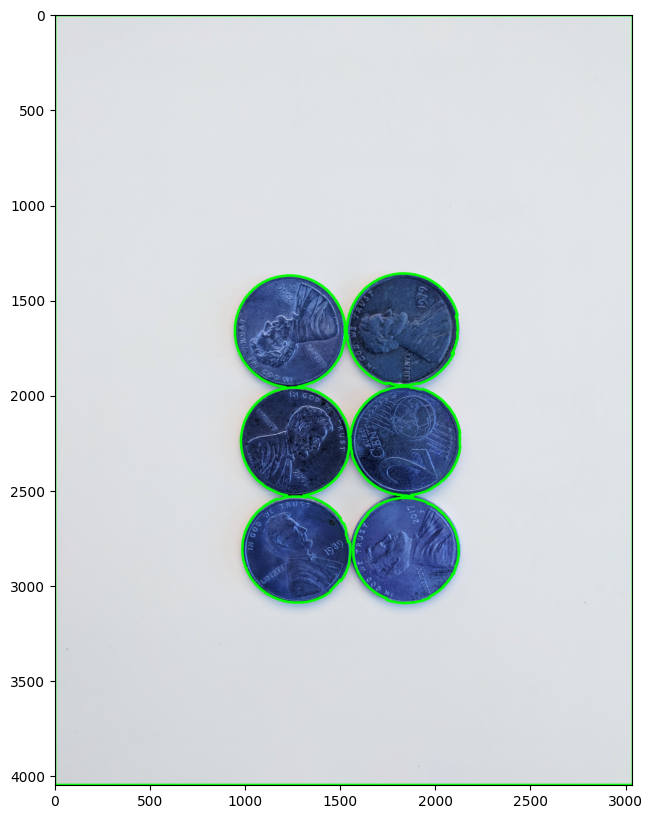

In [74]:
watershed_contours, watershed_heirarcy = cv.findContours(
    watershed_results, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)


# draw on separate coins
for i in range(len(watershed_contours)):
    if watershed_heirarcy[0][i][3] == -1:
        cv.drawContours(separate_coins, watershed_contours, i, (0,255, 0), 10)

display(separate_coins)

# Great Success